# Fit atmosphere parameters VAOD, PWV, O3, including clouds OD

- author Sylvie Dagoret-Campagne

- creation date August 19th 2020 : remove Rayleigh, add Linear (No reg) fit, mag or no mag fit
- update August 21th to add plot/histo routines
- update August 22th 2020 : increase length of learning curves
- update August 22th 2020 : extent atmospheric transmission fit to spectrum fit
- update August 24th 2020 : correct bug on learning curves (use full test dataset)


# imports

In [345]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [346]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [347]:
from astropy.table import Table

In [348]:
from scipy import interpolate

In [349]:
# analytic for removing rayleigh
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [350]:
import libatmscattering as atm

In [351]:
# pysynphot
import pysynphot as S

In [352]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')

In [353]:
import scipy.special as sp

In [354]:
PATH_LSSTFiltersKG='../../data/lsst/LSSTFiltersKG'
sys.path.append(PATH_LSSTFiltersKG)
PATH_LSSTFiltersKGDATA='../../data/lsst/LSSTFiltersKG/fdata'
sys.path.append(PATH_LSSTFiltersKGDATA)

In [355]:
import libLSSTFiltersKG as lsst

# Functions

In [356]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

## Functions to select the CALSPEC

In [357]:
def GetListOfCalspec(file_sedsummary="sed/table_summary_allcalspec_torenorm.fits"):
    """
    GetListOfCalspec()
    
    the file include SED fro which color term has been caculated 
    in /examples_sed/calspec/ViewCalspecColors.ipynb
    
    - input:
      file_sedsummary : filename of SED summary
      
    - output:
      t : astropy table of summary 
    """

    t=Table.read(file_sedsummary)
    return t

In [358]:
def SelectFewSED(t):
    """
    SelectFewSED(t)
    
    input : 
     - t astropy table of SED
     
    output :
    - t_selected : table of presselected SED
     
    """
    
    all_colors=t["VmI"]
    
    
    # list of target colors
    target_VmI=np.array([-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1])
    NBVmItarget=len(target_VmI)
    
    filesselected_index=np.zeros(NBVmItarget)
    filesselected_VmI=np.zeros(NBVmItarget)
    
    idx=0
    for vmi in target_VmI:
        thevmi,theidx=find_nearest(all_colors,vmi)
        #print(thevmi,theidx)
        filesselected_index[idx]=int(theidx)
        filesselected_VmI[idx]=thevmi
        idx+=1  
        
    t_selected=Table(t[0])
    for idx in filesselected_index[1:]:
        t_selected.add_row(t[int(idx)])
        
    return t_selected
    

In [359]:
def plot_sed(t,ax):
    """
    """
    
    NBFILES=len(t)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)
    
    idx=0
    
    flatsp = S.FlatSpectrum(10, fluxunits='photlam')

    for filename in t["FILES"]:
    
    
        fullfilename=os.path.join(path_sed_calspec,filename)
        
        if filename=="flat":
            spec=flatsp
            spec_norm=spec
        else:
            spec=S.FileSpectrum(fullfilename)
        
        spec_norm = spec.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
    
        spec_norm.convert('photlam')
        #spec_norm.convert('nm')    
        
        #WLMINSEL=340.
        #WLMAXSEL=1100.


        magV=t["magV"][idx]
        label=t["OBJNAME"][idx]+" ( "+t["SP_TYPE"][idx]+" ) "+" magV = {:.2g}".format(magV) +" v-i ={:.2f}".format(t["VmI"][idx])
        
        
        
        #X= spec_norm.wave[wavelengths_indexes]    
        #Y= spec_norm.flux[wavelengths_indexes]  
        
        X= spec_norm.wave   
        Y= spec_norm.flux 
        
        wavelengths_indexes=np.where(np.logical_and(spec_norm.wave>WLMINSEL*10, spec_norm.wave<WLMAXSEL*10))[0]
        
        
        #if filename!="flat":
        cm=ax.plot(X[wavelengths_indexes], Y[wavelengths_indexes],color=all_colors[idx],label=label)
        
        idx+=1
    
    #ax.set_xlim(3500.,11000.)
    #ax.set_ylim(0.,3.)
    ax.legend()
    ax.grid()


    xlabel=' $\\lambda$ (Angstrom)'
    ylabel=' Flux (photlam) normalised to Mag-10'
    ax.set_xlabel(xlabel,fontsize=15)
    ax.set_ylabel(ylabel,fontsize=15)
    ax.set_title("Preselected CALSPEC relative SED")
    
    return cm

    
    

## Functions to build spectrum 

In [360]:
def GetSpectra(sed,wl_atm,atm_transmission, order2=False):
    """
    
    * input : 
     - sed : Pysynphot SED
     -  wl  : wavelength of the atmospheric transmission (nm)
     - transmission : atmospheric transmission array
     - order2 : flag to compute the atmospheric transmission
     
    * output :
     - array of spectra (corresponding to wl in nm)
    
    """
    
    wl0=sed.wave  # in angstrom
    spectra=np.zeros_like(atm_transmission)
    spectra2=np.zeros_like(atm_transmission)  # order 2
    
    wl_atm_ang=10*wl_atm
    
    
    
    # quantum efficiency
    wl_ccd,throughput,ccdqe,trans_opt_elec=lsst.GetThroughputAndCCDQE("../../data/lsst")
    bp_qe= S.ArrayBandpass(wl_ccd*10.,ccdqe, name='QE')
    
    
    
    # passband for atmosphere
    Natm=atm_transmission.shape[0]
    all_bp_atm=[]
    for i_atm in np.arange(Natm):
        label_atm="atm{:d}".format(i_atm)
        bp_atm= S.ArrayBandpass(wl_atm_ang,atm_transmission[i_atm,:], name=label_atm)
        all_bp_atm.append(bp_atm)
        
    # Hologram transmission (analytic)
    X0=10000 # in antstrom
    X=wl0
    X2=np.sort(np.unique(np.concatenate((wl0/2,wl0)))) 
    Eff_holo=sp.jv(1, X0/X)**2
    Eff_holo2=sp.jv(2, X0/X2)**2
    
    bp_holo_order1= S.ArrayBandpass(X,Eff_holo, name='Holo')
    bp_holo_order2= S.ArrayBandpass(X2,Eff_holo2, name='Holo2')
    
    all_obs1=[]
    all_obs2=[]
    
    # compute spectra for order 1 and order 2
    for i_atm in np.arange(Natm):
        bp_all_order1=bp_qe*all_bp_atm[i_atm]* bp_holo_order1
        bp_all_order2=bp_qe*all_bp_atm[i_atm]* bp_holo_order2

        obs1 = S.Observation(sed, bp_all_order1,force='taper') # order 1
        obs2 = S.Observation(sed, bp_all_order2,force='taper') # order 2
    
        all_obs1.append(obs1)
        all_obs2.append(obs2)
        
   
    for i_atm in np.arange(Natm):
        obs1=all_obs1[i_atm]
        func_order1 = interpolate.interp1d(obs1.binwave,obs1.binflux,bounds_error=False,fill_value=(0,0))
    
        spectra[i_atm,:]=func_order1(wl_atm_ang) 
    
        obs2=all_obs2[i_atm]
        func_order2 = interpolate.interp1d(2*obs2.binwave,obs2.binflux/2,bounds_error=False,fill_value=(0,0))
        spectra2[i_atm,:]=func_order2(wl_atm_ang) 
        
    # add order 1 + order 2    
    if order2:
        spectra=spectra+spectra2
        
    spectra=spectra*10 # to get per unit of nm
    spectra2=spectra2*10
    
    return spectra,spectra2
    
    

In [361]:
if 0:
    spectra,spectra2=GetSpectra(sed=spec_norm,wl_atm=wl,atm_transmission=transm[:22,:],order2=True)
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    for idx in np.arange(20):
        ax.plot(wl,spectra[idx,:])
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax.grid()
    
    ax = fig.add_subplot(122)
    for idx in np.arange(20):
        ax.plot(wl,spectra2[idx,:])
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax.grid()

## Functions for Plotting

In [362]:
def plot_param(iparam,ax,all_Yin,all_Yout,mode,nsig=10):
    """
    plot parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    xlabel=["VAOD in ","PWV in (mm)","Ozone in (dBU)","Cloud OD in "]
    ylabel=["value out","value rec - value in","$\delta V/V$"]
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]
     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    
    if mode   ==0:  
        cm=ax.plot(Y0,Y1,"o",color=all_colors[iparam])
    elif mode ==1:
        
        mu = DY.mean()
        median = np.median(DY)
        sigma = DY.std()
        textstr = '\n'.join((
        r'$\mu$={:3.2g}'.format(mu),
        r'$median$={:3.2g}'.format(median),
        r'$\sigma$={:3.2g}'.format(sigma)))
        
       
        cm=ax.plot(Y0,DY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)
        
    else:
        
        mu = RY.mean()
        median = np.median(RY)
      
        sigma = RY.std()
        
        
        textstr = '\n'.join((
        '$\mu$={:.3g}'.format(mu),
        '$median$={:.3g}'.format(median),
        '$\sigma$={:.3g}'.format(sigma)))
       
        
        
        cm=ax.plot(Y0,RY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
            
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)    
            
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_ylabel(ylabel[mode])

    
    ax.ticklabel_format(axis='y',style='sci', 
                          scilimits=None, 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [363]:
def plot_param_histo(iparam,ax,all_Yin,all_Yout,nsig=10):
    """
    plot histo of parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    

    xlabel=["$\Delta$ VAOD","$\Delta$ PWV (mm)","$\Delta$ Ozone (dBU)","$\Delta$ OD"]
   
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]

    
    mu = DY.mean()
    median = np.median(DY)
    sigma = DY.std()
    textstr = '\n'.join((
    '$\mu$={:.3g}'.format(mu),
    '$median$={:.3g}'.format(median),
    '$\sigma$={:.3g}'.format(sigma)))
   
    
    cm=ax.hist(DY,bins=50,color=all_colors[iparam])
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_xlim(mu-nsig*sigma,mu+nsig*sigma)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
 
    ax.ticklabel_format(axis='x', 
                          style='sci',
                          scilimits=(-3,-3), 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [364]:
DATADIR="../../data/atm"

In [365]:
atmospheric_basename_files=os.listdir(DATADIR)

In [366]:
atmospheric_basename_files

['lsst_atm_10year_bintab.parquet',
 'lsst_atm_10year_01.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_bintab.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_bintab_small.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_03.fits',
 '.ipynb_checkpoints',
 'lsst_atm_10year_02.fits']

In [367]:
input_file=os.path.join(DATADIR,'lsst_atm_10year_bigimg.fits')

In [368]:
hdu = fits.open(input_file)

In [369]:
hdr=hdu[0].header
data=hdu[0].data

In [370]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  958                                                  
NAXIS2  =                 3651                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [371]:
#NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [372]:
num=data[1:,idx_out_num]
year=data[1:,idx_out_year]
airmass=data[1:,idx_out_year]
vaod=data[1:,idx_out_vaod] # vertical aerosol depth
pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[1:,idx_out_o3]     # ozone
cld=data[1:,idx_out_cld]   # clouds (not used)

In [373]:
# Extract wavelength Wavelength
wl=data[0,idx_out_res:]
transm_tot=data[1:,idx_out_res:]

### Select wavelength range

In [374]:
WLMINSEL=340.
WLMAXSEL=1100.

In [375]:
indexes_selected=np.where(np.logical_and(wl>=WLMINSEL,wl<=WLMAXSEL))[0]

In [376]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [377]:
len(indexes_selected)

760

In [378]:
wl=wl[indexes_selected]
transm_tot=transm_tot[:,indexes_selected]

### Remove rayleigh component

In [379]:
od_rayl=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
att_rayleigh=np.exp(-od_rayl)

In [380]:
transm=transm_tot/att_rayleigh

### Not removing the rayleigh

In [381]:
transm=transm_tot

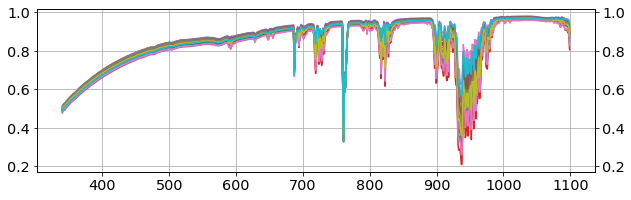

In [382]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
for idx in np.arange(20):
    ax.plot(wl,transm[idx,:])
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax.grid()

In [383]:
NWL=wl.shape[0]

In [384]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data : X and Y

In [385]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]

## Clouds

## clouds in input data

In [386]:
od_cloud_data=(cld-cld.min())/100
transm_cloud_data=np.exp(-od_cloud_data)

### add simulated clouds

In [387]:
od_cloud_sim=np.random.rand(len(vaodarr))
transm_cloud_sim=np.exp(-od_cloud_sim)

Text(0.5, 0, 'cloud optical depth')

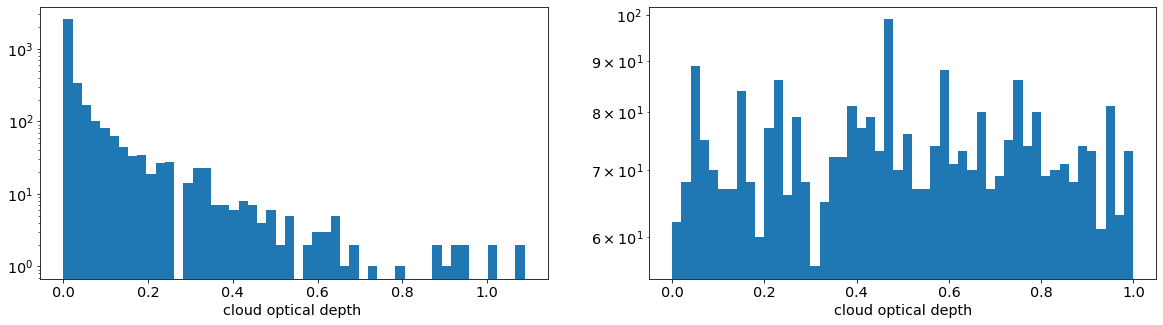

In [388]:
fig=plt.figure(figsize=(20,5))

ax = fig.add_subplot(121)
plt.hist(od_cloud_data,bins=50,label="in data")
ax.set_yscale('log')
ax.set_xlabel("cloud optical depth ")

ax = fig.add_subplot(122)
plt.hist(od_cloud_sim,bins=50,label="in sim")
ax.set_yscale('log')
ax.set_xlabel("cloud optical depth")

In [389]:
FLAG_CLOUD_SIM=True
if FLAG_CLOUD_SIM:
    cldarr=od_cloud_sim
else:
    cldarr=od_cloud_data
    
transm_cloud=np.exp(-cldarr)
transm_cloud=transm_cloud[:,np.newaxis]
cldarr=cldarr[:,np.newaxis]

### concatenate VAOD,PWV, Ozone

In [390]:
Y=np.concatenate((vaodarr,pwvarr,o3arr,cldarr),axis=1)

### Use magnitudes for X

In [391]:
t=GetListOfCalspec()
t_sel=SelectFewSED(t)


In [392]:
t_sel

OBJNAME,RA,DEC,SP_TYPE,SP_QUAL,magU,magB,magV,magR,magI,FILES,calcU,calcB,calcV,calcR,calcI,factor,VmI
bytes10,float64,float64,bytes12,bytes1,float64,float32,float64,float64,float64,bytes27,float64,float64,float64,float64,float64,float64,float64
NGC7293,337.411,-20.837,DAO.5,C,11.894,13.158,13.524,13.689,13.898,ngc7293_005.fits,11.917,13.180,13.538,13.734,14.234,26.01,-0.697
G93-48,328.106,2.389,DA2.8,C,11.942,12.732,12.743,12.839,12.938,g93_48_004.fits,11.982,12.717,12.728,12.836,13.234,12.34,-0.506
HZ4,58.842,9.788,DA3.4,C,13.917,14.592,14.506,14.580,14.642,hz4_stis_005.fits,13.961,14.593,14.473,14.569,14.723,61.551,-0.250
ALPHA_LYR,279.235,38.784,A0Va,C,0.030,0.030,0.030,0.070,0.100,alpha_lyr_stis_008.fits,0.021,0.017,0.009,0.000,-0.004,0.00010079,0.013
HD163466,268.106,60.396,A2,E,100000000000000000000.000,7.040,6.850,100000000000000000000.000,100000000000000000000.000,hd163466_stis_004.fits,7.161,7.036,6.839,6.694,6.589,0.054409,0.251
HD074000,130.212,-16.345,F2,D,9.840,10.090,9.660,100000000000000000000.000,100000000000000000000.000,hd074000_stis_003.fits,9.852,10.065,9.645,9.269,8.987,0.72107,0.658
HD106252,183.373,10.042,G0,E,100000000000000000000.000,8.000,100000000000000000000.000,7.000,100000000000000000000.000,hd106252_stis_004.fits,8.117,8.020,7.403,6.957,6.653,0.091453,0.750
FLAT,0.000,0.000,flat,0,9.721,10.369,10.000,9.501,9.001,flat,9.721,10.369,10.000,9.501,9.001,1,0.999


### Show examples of SED to use

Warning, 44 of 7210 bins contained negative fluxes; they have been set to zero.
Warning, 19 of 6265 bins contained negative fluxes; they have been set to zero.


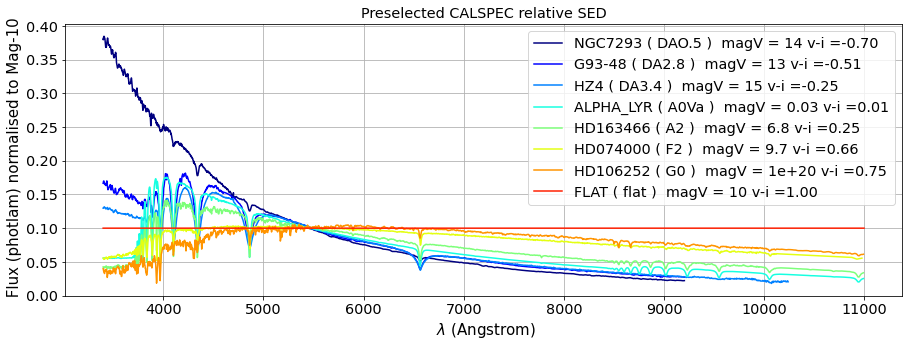

In [393]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)
plot_sed(t_sel,ax)
plt.show()

### Get the Spectrum

In [394]:
idx_sed_sel=3
sed_filename=t_sel[idx_sed_sel]["FILES"]
sed_objname=t_sel[idx_sed_sel]["OBJNAME"]
sed_fullfilename=os.path.join(path_sed_calspec,sed_filename)
order2=True
if order2:
    specarrayfile="spec_"+sed_objname+"_ord12.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2.npy"
    title_spec1="spectra order 1 and 2"
    title_spec2="spectra order 2"
else:
    specarrayfile="spec_"+sed_objname+"_ord1.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2.npy"
    title_spec1="spectra order 1"
    title_spec2="spectra order 2"

In [395]:
specarrayfile

'spec_ALPHA_LYR_ord12.npy'

In [396]:
specarrayfile2

'spec2_ALPHA_LYR_ord2.npy'

In [397]:
if sed_filename=="flat":
    flatsp = S.FlatSpectrum(10, fluxunits='photlam')
    spec=flatsp
else:
    spec=S.FileSpectrum(sed_fullfilename)
        
spec_norm = spec.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
    
spec_norm.convert('photlam')

In [398]:
if not os.path.isfile(specarrayfile) or not os.path.isfile(specarrayfile2) :
    spectra,spectra2=GetSpectra(sed=spec_norm,wl_atm=wl,atm_transmission=transm,order2=order2)
    np.save(specarrayfile,spectra)
    np.save(specarrayfile2,spectra2)   
else:
    spectra=np.load(specarrayfile)
    spectra2=np.load(specarrayfile2)

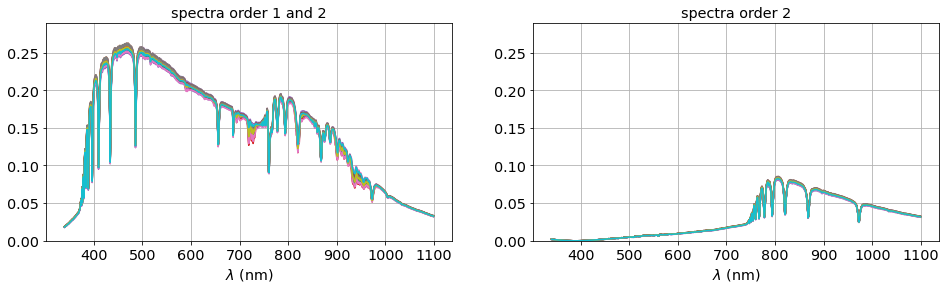

In [399]:
if 1:
    themax=0
    themin=0
    
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    for idx in np.arange(20):
        if spectra[idx,:].max()>themax:
            themax=spectra[idx,:].max()
        ax.plot(wl,spectra[idx,:])
    ax.set_ylim(0,1.1*themax)
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_title(title_spec1)
    
    ax = fig.add_subplot(122)
    for idx in np.arange(20):
        ax.plot(wl,spectra2[idx,:])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylim(0,1.1*themax)
    ax.set_title(title_spec2)
    ax.grid()

In [400]:
FLAG_MAG=True
if FLAG_MAG:
    X=-2.5*np.log10(spectra*transm_cloud)
else:
    X=spectra*transm_cloud

### Check transmission or spectrum

(1.2752680691785856, 5.474754423708954)

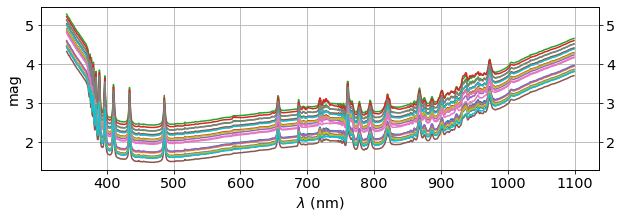

In [401]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
for idx in np.arange(20):
    ax.plot(wl,X[idx,:])
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("mag")
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())

## Splitting

In [402]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [403]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

## Scaling

In [404]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [405]:
FLAG_SCALING=True

In [406]:
scaler_X.fit(X_train) 
scaler_Y.fit(Y_train) 

StandardScaler()

In [407]:
scaler_X.mean_.shape

(760,)

In [408]:
scaler_X.scale_.shape

(760,)

In [409]:
scaler_Y.mean_.shape

(4,)

In [410]:
scaler_Y.scale_.shape

(4,)

In [411]:
X_train_scaled = scaler_X.transform(X_train)
Y_train_scaled = scaler_Y.transform(Y_train)    
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

Text(0.5, 1.0, 'Renormalised target (VAOD, O3, PWV,CLD)')

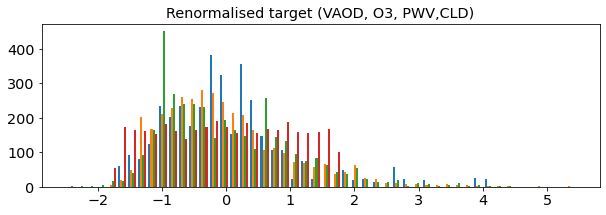

In [412]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.hist(np.concatenate((Y_train_scaled,Y_val_scaled,Y_test_scaled),axis=0),bins=50)
ax.set_title("Renormalised target (VAOD, O3, PWV,CLD)")

## Linear regression model

In [413]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [414]:
reg = linear_model.LinearRegression()

In [415]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [416]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets

if FLAG_SCALING:
    regr.fit(X_train_scaled, Y_train_scaled)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test_scaled)
else:
    regr.fit(X_train, Y_train)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)



# The coefficients
print('Coefficients: \n', regr.coef_)
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))


Coefficients: 
 [[-1.91882605e+02  5.60589438e+01 -1.61216910e+01 ...  3.33836400e+05
  -7.48148782e+04  1.99633662e+03]
 [-1.01080555e-01 -3.04474283e-01 -1.04356704e-01 ... -4.67920673e+03
   1.00223797e+03 -1.38618197e+02]
 [-3.30753192e+00  3.60275392e+00  2.56055824e+00 ... -6.85953151e+03
   1.39103286e+03 -1.42052533e+02]
 [ 1.42296550e+01 -4.16952456e+00  1.18332952e+00 ... -2.47073579e+04
   5.53796035e+03 -1.47183941e+02]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


# Linear Regression with Ridge

In [417]:
from sklearn import linear_model
regr_ridge = linear_model.Ridge(alpha=1e-5)

In [418]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_ridge.fit(X_train_scaled, Y_train_scaled)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test_scaled)
else:
    regr_ridge.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test)

print(regr_ridge)

# The coefficients
print('Coefficients: \n', regr_ridge.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))

Ridge(alpha=1e-05)
Coefficients: 
 [[-2.43873645 -1.96339551 -1.75049416 ...  0.88555699  0.97124048
   1.10092598]
 [ 0.06661497  0.05110809  0.04456004 ...  0.04233693  0.04643765
   0.05583906]
 [ 3.70068229  2.70826046  2.26262878 ... -0.14547427 -0.15653945
  -0.1628645 ]
 [ 0.16295078  0.13272855  0.11921028 ... -0.06057312 -0.06682659
  -0.07635428]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


## Tune hyper parameter with Ridge

In [419]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)
all_MSE = []

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    
    if FLAG_SCALING:
    
        ridge.fit(X_train_scaled,Y_train_scaled)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        ridge.fit(X_train,Y_train)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE result
    all_MSE.append(MSE)
    
allcoefs=np.array(coefs)
alphas=np.array(alphas)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.37671e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.84224e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.7672e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00372e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.21351e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dago

<Figure size 1080x1080 with 0 Axes>

In [420]:
RIDGE_MSE_THRES=[
    1e-7,
    0.016,      #level 1
    3e-6,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

In [421]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [422]:
alpha_ridge_min=alphas[idx_min]
alpha_ridge_min

1e-10

1.3200884008314169e-07

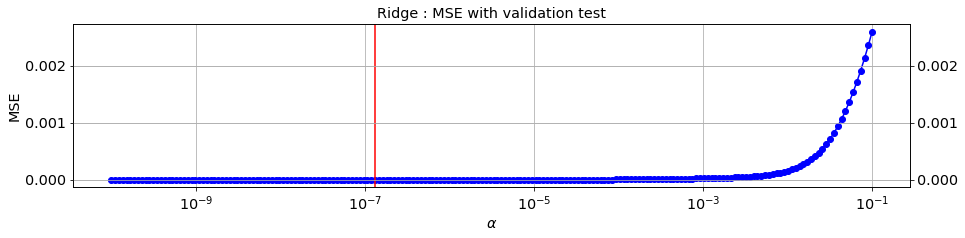

In [423]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
if FLAG_MAG:
    idx_min=np.where(all_MSE<1e-6)[0][-1]
else:
    idx_min=np.where(all_MSE<1e-6)[0][-1]
alpha_ridge=alphas[idx_min]
ax.axvline(x=alpha_ridge,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()
alpha_ridge

### Display results

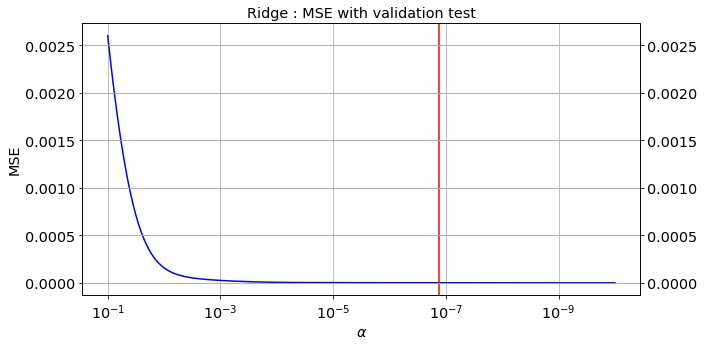

In [424]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.axvline(x=alpha_ridge,color='red')
ax.grid()
#ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

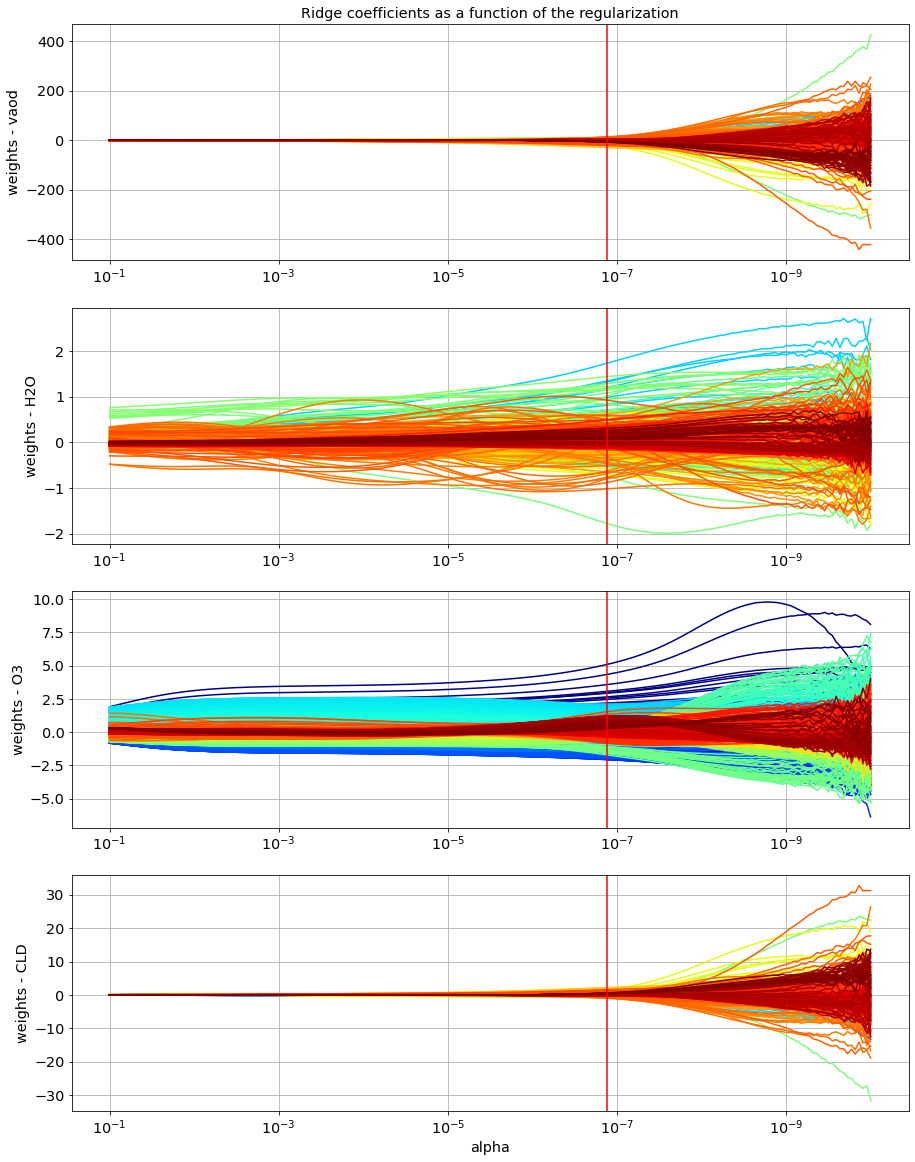

In [425]:
fig=plt.figure(figsize=(15,20))

ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs.shape[2]):
    ax1.plot(alphas, allcoefs[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.axvline(x=alpha_ridge,color='red')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Ridge coefficients as a function of the regularization')

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax2.plot(alphas, allcoefs[:,1,idx],color=all_colors[idx])
ax2.axvline(x=alpha_ridge,color='red')
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax3.plot(alphas, allcoefs[:,2,idx],color=all_colors[idx])
ax3.axvline(x=alpha_ridge,color='red')
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax4.plot(alphas, allcoefs[:,3,idx],color=all_colors[idx])
ax4.axvline(x=alpha_ridge,color='red')
ax4.set_ylabel('weights - CLD')
ax4.set_xscale('log')
#ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.set_xlim(ax4.get_xlim())  # reverse axis
ax4.grid(True)


plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Linear Regression with Lasso

In [426]:
from sklearn import linear_model

In [427]:
regr_lasso = linear_model.Lasso(alpha=1e-5)

In [428]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_lasso.fit(X_train_scaled, Y_train_scaled)
    Y_pred_lasso = regr_lasso.predict(X_test_scaled)
    
else:
    regr_lasso.fit(X_train, Y_train)
    Y_pred_lasso = regr_lasso.predict(X_test)
    
    
# The coefficients
print('Coefficients: \n', regr_lasso.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_lasso))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_lasso))

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233.25012684170548, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.847514521256, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1077.2641274544005, tolerance: 0.2190000000000001
  positive)


Coefficients: 
 [[ 2.41404761e+01 -9.75922568e-02 -1.14405294e-01 ... -2.21401533e-02
  -0.00000000e+00  8.90276820e-06]
 [-1.47810959e-01 -8.13865458e-03 -4.43321463e-03 ... -6.62682151e-03
  -0.00000000e+00  3.59278934e-02]
 [-1.23359727e+00 -1.49263407e+00 -6.50671157e-01 ...  1.88003991e-02
   2.67940693e-02  3.97411550e-02]
 [-1.44925338e+00  2.76445312e-03  1.37027155e-02 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]]
Mean squared error: 0.31932
Coefficient of determination: 0.69924
Explained variance: 0.69955


/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.442105936877349, tolerance: 0.21900000000000014
  positive)


In [429]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 20
alphas = np.logspace(-10, -1, n_alphas)

all_MSE = []
coefs = []
coefs_noconst = []

for a in alphas:
    # fit with intercept
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True,max_iter=1000)
    # fit without intercept
    lasso2 = linear_model.Lasso(alpha=a, fit_intercept=False,max_iter=1000)
        
    if FLAG_SCALING:
        lasso.fit(X_train_scaled,Y_train_scaled);
        lasso2.fit(X_train_scaled,Y_train_scaled);
    else:
        lasso.fit(X_train,Y_train);
        lasso2.fit(X_train,Y_train);
            
    # book coefficients        
    coefs.append(lasso.coef_) 
    coefs_noconst.append(lasso2.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    
    if FLAG_SCALING:
        Y_pred = lasso.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        Y_pred = lasso.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE    
    all_MSE.append(MSE)

alphas=np.array(alphas)
allcoefs=np.array(coefs)
allcoefs2=np.array(coefs_noconst)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231.09843678375455, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.01205954807773, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1079.7337309436075, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1079.7331135940865, tolerance: 0.219
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.213598782148344, tolerance: 0.21900000000000014
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231.10014779236386, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231.1440831007405, tolerance: 0.2189999999999995
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.051676284854638, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1079.6834014595825, tolerance: 0.219
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase th

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1075.6879018187835, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.55713703440204, tolerance: 0.21900000000000014
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 234.82516305748067, tolerance: 0.2189999999999995
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349.8417580282955, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.63497664704339, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 662.3278654934599, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

<Figure size 1080x1080 with 0 Axes>

In [430]:
LASSO_MSE_THRES=[
    1e-7,
    0.016,      #level 1
    3e-6,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

In [431]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [432]:
alpha_lasso_min=alphas[idx_min]
alpha_lasso_min

0.0012742749857031321

0.0012742749857031321

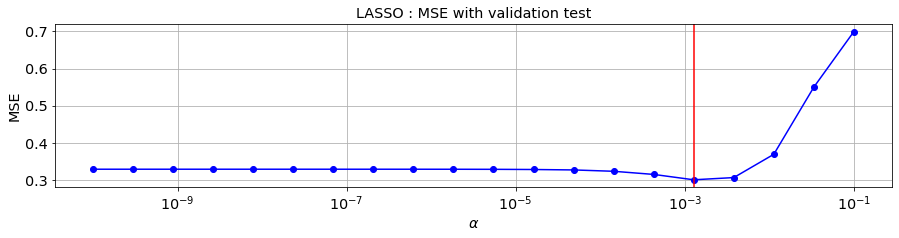

In [433]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
if FLAG_MAG:
    idx_min=np.where(all_MSE==all_MSE.min())[0][0]
else:
    idx_min=np.where(all_MSE==all_MSE.min())[0][0]
alpha_lasso=alphas[idx_min]
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax.grid()
alpha_lasso

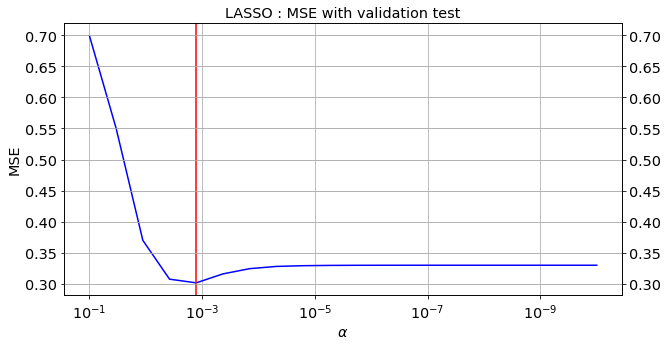

In [434]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

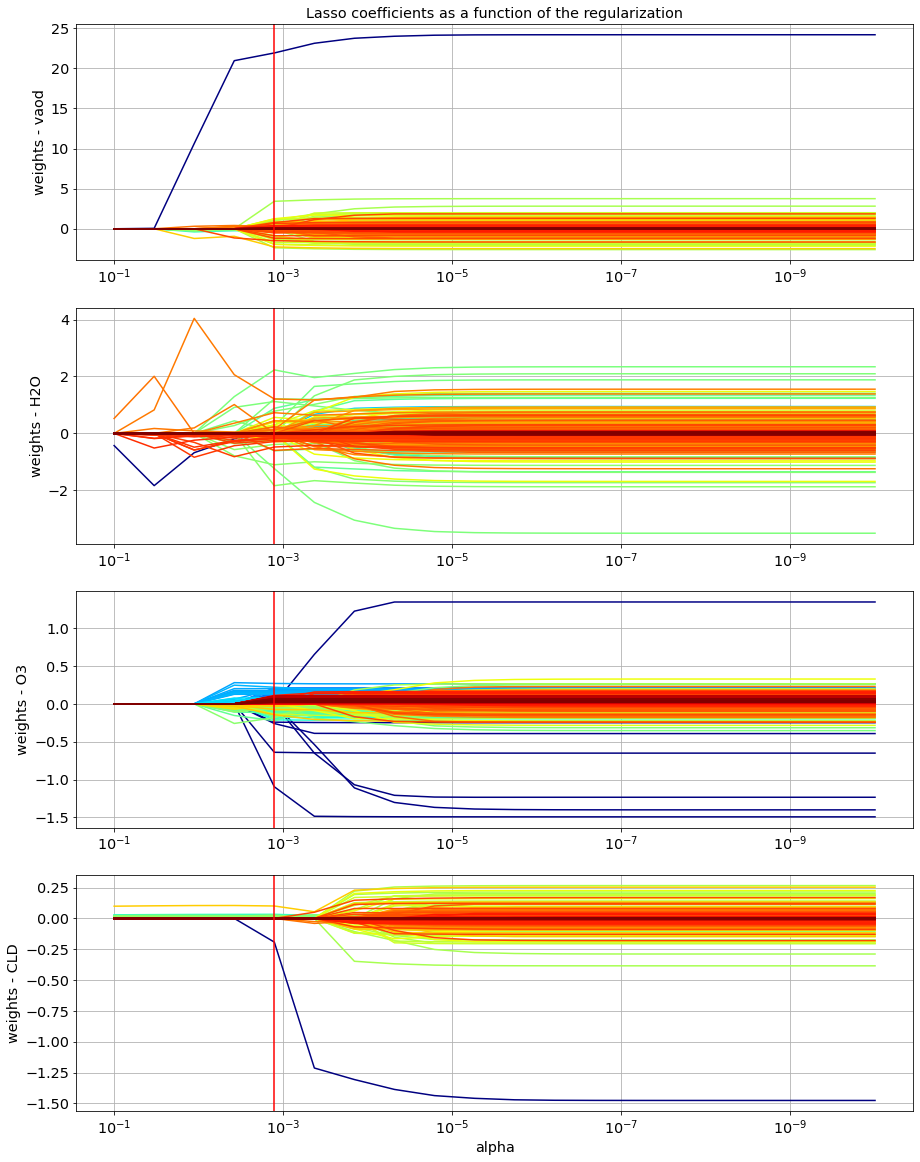

In [435]:
fig=plt.figure(figsize=(15,20))
ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs2.shape[2]):
    ax1.plot(alphas, allcoefs2[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.axvline(x=alpha_lasso,color='red')
ax1.grid(True)
ax1.set_title('Lasso coefficients as a function of the regularization')

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs2.shape[2]):
    ax2.plot(alphas, allcoefs2[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.axvline(x=alpha_lasso,color='red')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax3.plot(alphas, allcoefs2[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.axvline(x=alpha_lasso,color='red')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax4.plot(alphas, allcoefs2[:,3,idx],color=all_colors[idx])
ax4.set_ylabel('weights - CLD')
ax4.axvline(x=alpha_lasso,color='red')
ax4.set_xscale('log')
#ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.set_xlim(ax4.get_xlim())  # reverse axis
ax4.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Verification with test  set

## Check learning curves

In [436]:
nb_tot_test=len(Y_test)
nb_tot_train=len(Y_train)

In [437]:
nsamples_test=np.arange(10,nb_tot_test,10)
nsamples_train=np.arange(10,nb_tot_train,10)

### Leraning curves for linear regression

In [438]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [439]:
count=0
for n in nsamples_train:
    
    regr = linear_model.LinearRegression(fit_intercept=True)
  
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    # does the fit    
    regr.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = regr.predict(X_train_cut)
    if n in nsamples_test:
        Y_pred_test  = regr.predict(X_test_cut)
        
    if FLAG_SCALING:     
        Y_pred_test_full = regr.predict(np.copy(X_test_scaled))
    else:
        Y_pred_test_full = regr.predict(np.copy(X_test))
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)
        
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
         MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full) 
            
    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
        
    
    count+=1
    # end of loop
    

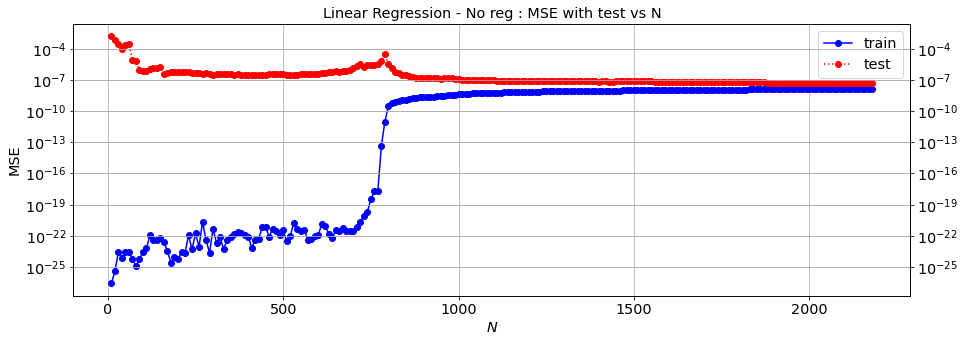

In [440]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r:o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("Linear Regression - No reg : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Ridge

In [441]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [442]:
count=0
for n in nsamples_train:
    

    ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    ridge.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = ridge.predict(X_train_cut)
    
    if FLAG_SCALING:  
        Y_pred_test_full = ridge.predict(X_test_scaled)
    else:
        Y_pred_test_full = ridge.predict(X_test)
        
        
    if n in nsamples_test:
        Y_pred_test  = ridge.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
        MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full)   
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.02497e-16): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.00187e-16): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=9.89019e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=8.5528e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=9.84309e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/a

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.29377e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.12508e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.12969e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.81958e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.73316e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.5015e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.01697e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.47363e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.77999e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.83525e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dago

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.2393e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.2437e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.4044e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.13006e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.19441e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagore

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.59378e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.55619e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.6933e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.70004e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.52086e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dago

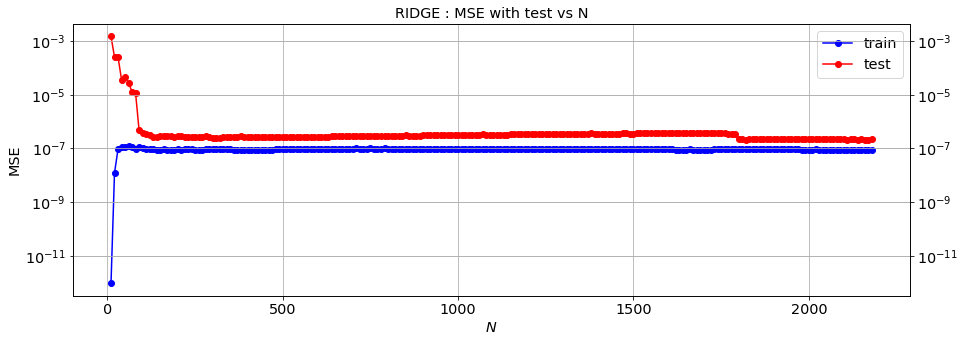

In [443]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("RIDGE : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Lasso

In [444]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [445]:
alpha_lasso

0.0012742749857031321

In [446]:
alpha_lasso_min

0.0012742749857031321

In [447]:
alpha_lasso_0=1e-3

In [448]:
count=0
for n in nsamples_train:
    

    lasso = linear_model.Lasso(alpha=alpha_lasso_0, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    lasso.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = lasso.predict(X_train_cut)
    
    if FLAG_SCALING:  
        Y_pred_test_full = lasso.predict(X_test_scaled)
    else:
        Y_pred_test_full = lasso.predict(X_test)
    
    if n in nsamples_test:
        Y_pred_test  = lasso.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    
    
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
        MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full)   
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4553481544676474, tolerance: 0.0009938346153402725
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09871713138648074, tolerance: 0.0003225237752955068
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.040192170957628, tolerance: 0.0007725971819792289
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04675911711737363, tolerance: 0.008023832215961825
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.149772833188983, tolerance: 0.007627531956997945
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4878732505571532, tolerance: 0.007376595533035448
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.61051386950658, tolerance: 0.018427301001749143
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08384346729806474, tolerance: 0.016071483052044658
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.761297970816983, tolerance: 0.012128889649494436
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.45168505329397, tolerance: 0.017303673396387814
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.963803010389304, tolerance: 0.02589378913908829
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.93467859436242, tolerance: 0.024120776295855444
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.65304304929606, tolerance: 0.03191562295473232
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18799298188100344, tolerance: 0.03141763204173209
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.77218772882645, tolerance: 0.026563438370096174
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.864400084414825, tolerance: 0.034840004219151434
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.990908484800407, tolerance: 0.04537654354953171
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.6725959039168, tolerance: 0.03943894286465572
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2884180125200939, tolerance: 0.044361962136924976
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.17140625475254, tolerance: 0.03948622197466694
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.650601880700155, tolerance: 0.05395056187540672
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.1032188077876, tolerance: 0.051854986976854686
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36853132785304765, tolerance: 0.05400138699033401
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.71506227700037, tolerance: 0.0506570731459987
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.98722352354767, tolerance: 0.058335922644011294
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.575798357608463, tolerance: 0.06725177595288326
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227.50294119964119, tolerance: 0.06496034609865653
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249.14135495775957, tolerance: 0.07140274738659846
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.504674540933264, tolerance: 0.06864388020115408
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.81426911273162, tolerance: 0.06586043327881043
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114.24104259592477, tolerance: 0.07325363222652718
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.879496393145672, tolerance: 0.08496153882564668
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 300.69083250927577, tolerance: 0.08327035195958751
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.1917343756395, tolerance: 0.08890852670368586
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5911785004484935, tolerance: 0.08260206634746786
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.2210104417302, tolerance: 0.08212819918935634
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139.78848909489142, tolerance: 0.0886440198624991
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.479659463580127, tolerance: 0.09812609080538882
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358.9180540922909, tolerance: 0.09906737013755813
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.0059269048312, tolerance: 0.10760705576432074
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7599538155808385, tolerance: 0.09920733948356418
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.82631914803233, tolerance: 0.09787616872772284
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164.15817537482212, tolerance: 0.10495103834867403
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.73916003750807, tolerance: 0.11148649979692378
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 419.91619112190585, tolerance: 0.1158007894615461
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444.8934849242871, tolerance: 0.12240773836932736
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8559644244185414, tolerance: 0.11400713717635595
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176.89323681698127, tolerance: 0.11091437707527382
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.06015221363742, tolerance: 0.12031552640217617
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.24166916873656, tolerance: 0.1246085597763501
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.7488439310928, tolerance: 0.13032770071281102
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 502.5960890513698, tolerance: 0.13837574395791194
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9708594556325361, tolerance: 0.12683679205201753
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.57883916615208, tolerance: 0.12699211316216452
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210.92073099975107, tolerance: 0.1348588318452117
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.590562069160924, tolerance: 0.1350678288536486
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 536.3794107983919, tolerance: 0.14726584696871195
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 553.2753967839587, tolerance: 0.15284432121231026
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.09118551096407, tolerance: 0.14233494072212338
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222.95688406472365, tolerance: 0.14300906171010694
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233.43884828462623, tolerance: 0.14830899244218337
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.11496316500798, tolerance: 0.15101586975241535
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.2659735363643, tolerance: 0.1596316112377662
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.6193386871877, tolerance: 0.16532883604551185
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1634114133374918, tolerance: 0.15763287573365964
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 244.66989587933858, tolerance: 0.1537665398807766
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257.4307933548812, tolerance: 0.1630313309456532
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.532770559993295, tolerance: 0.16447368484665403
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 613.3553999348378, tolerance: 0.17211564456359088
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 637.1644753980505, tolerance: 0.17941004781287148
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3436084467377891, tolerance: 0.17398095681355175
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270.6832103178641, tolerance: 0.1731409752274973
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281.286278123706, tolerance: 0.1783784133285984
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.293646407286346, tolerance: 0.18439302881311365
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 661.7118637490901, tolerance: 0.18734769346216387
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 692.3537414333076, tolerance: 0.19568297973458584
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4587556120709495, tolerance: 0.19013373049385196
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293.5979230756492, tolerance: 0.1854053533351138
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303.6437719966923, tolerance: 0.1935794250355082
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.06502364046757, tolerance: 0.1977885739295882
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 703.645289313607, tolerance: 0.20052148114146673
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to i

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 721.3450770461246, tolerance: 0.2062657359506782
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6160542933719126, tolerance: 0.20575438374674757
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316.0404582775216, tolerance: 0.20208577032469063
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327.45507893674954, tolerance: 0.20954416002896578
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.38727685721994, tolerance: 0.2110423815140087
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.9580098903532, tolerance: 0.21333611255979087
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

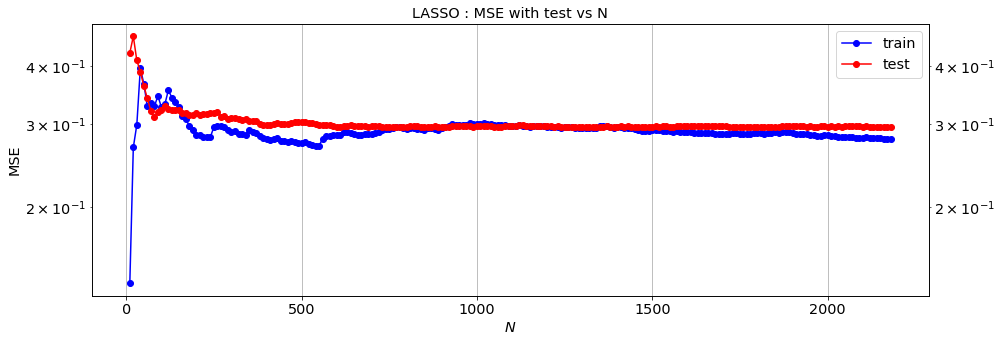

In [449]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r-o',label="test")
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with test vs N")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

# Final

# No regularisation

In [450]:
regr = linear_model.LinearRegression(fit_intercept=True)
    
if FLAG_SCALING:           
    regr.fit(X_train_scaled,Y_train_scaled)
else:
    regr.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = regr.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = regr.predict(X_test)
    DY=Y_pred_test-Y_test
    

In [451]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


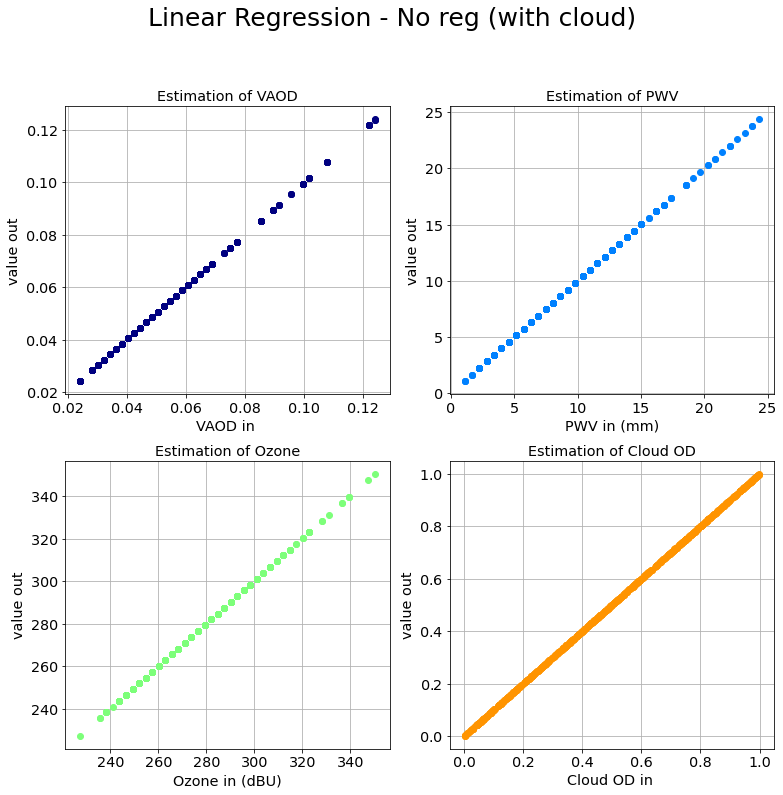

In [452]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

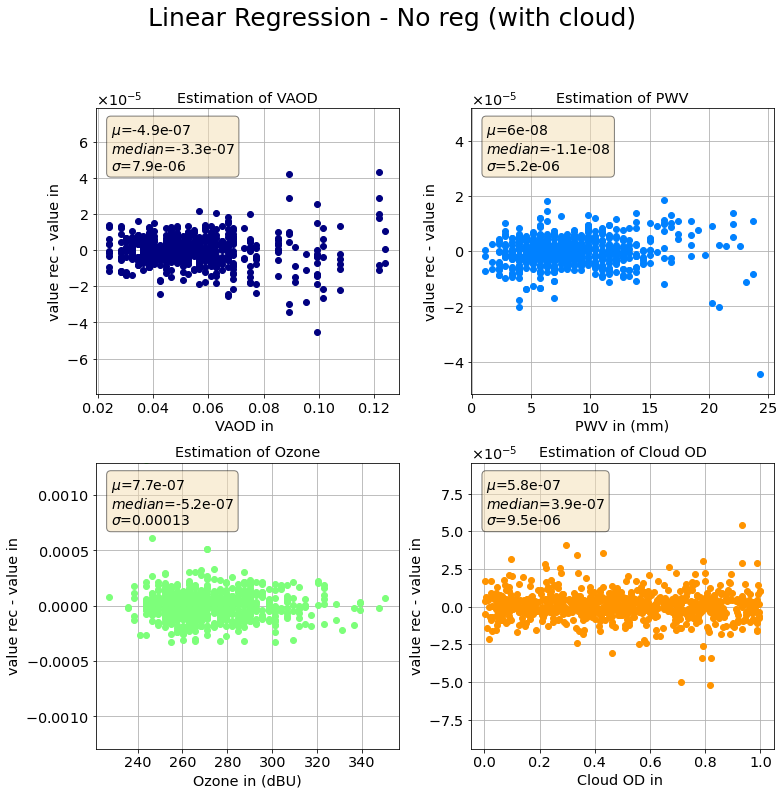

In [453]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

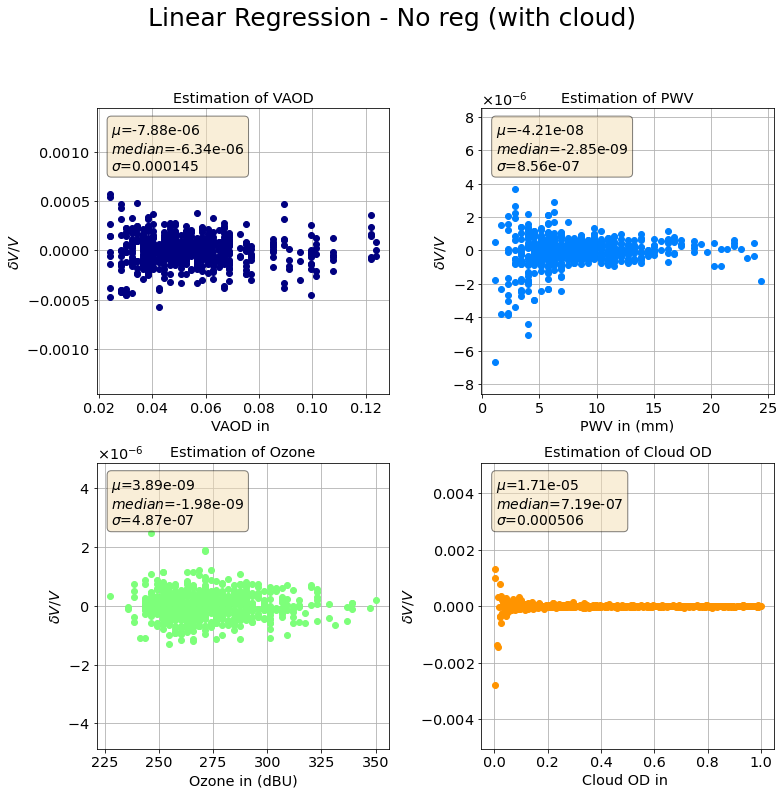

In [454]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

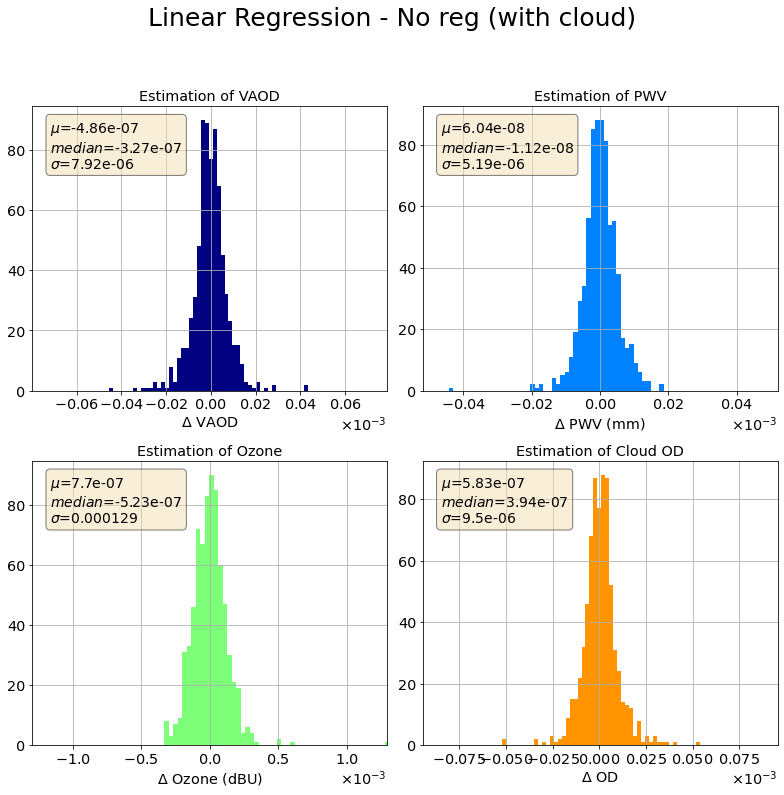

In [455]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()


## Ridge

In [456]:
ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
if FLAG_SCALING:           
    ridge.fit(X_train_scaled,Y_train_scaled)
else:
    ridge.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = ridge.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = ridge.predict(X_test)
    DY=Y_pred_test-Y_test
    
    


/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.37671e-18): result may not be accurate.
  overwrite_a=True).T


In [457]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


In [458]:
ridge.coef_

array([[-4.53572266e+01,  3.08838730e+01,  1.00215335e+01, ...,
        -7.99996390e+01, -7.99949669e+01, -5.26748070e+01],
       [ 7.75118837e-01,  6.46951247e-02,  1.28470427e-01, ...,
         4.37807567e-01,  4.03331700e-01, -6.64343003e-02],
       [ 2.90661753e+00,  6.24398094e+00,  4.89976217e+00, ...,
         1.34233948e+00,  1.18143075e+00,  1.88667969e+00],
       [ 3.34022241e+00, -2.31006946e+00, -7.66807814e-01, ...,
         5.92274227e+00,  5.93369092e+00,  3.91531665e+00]])

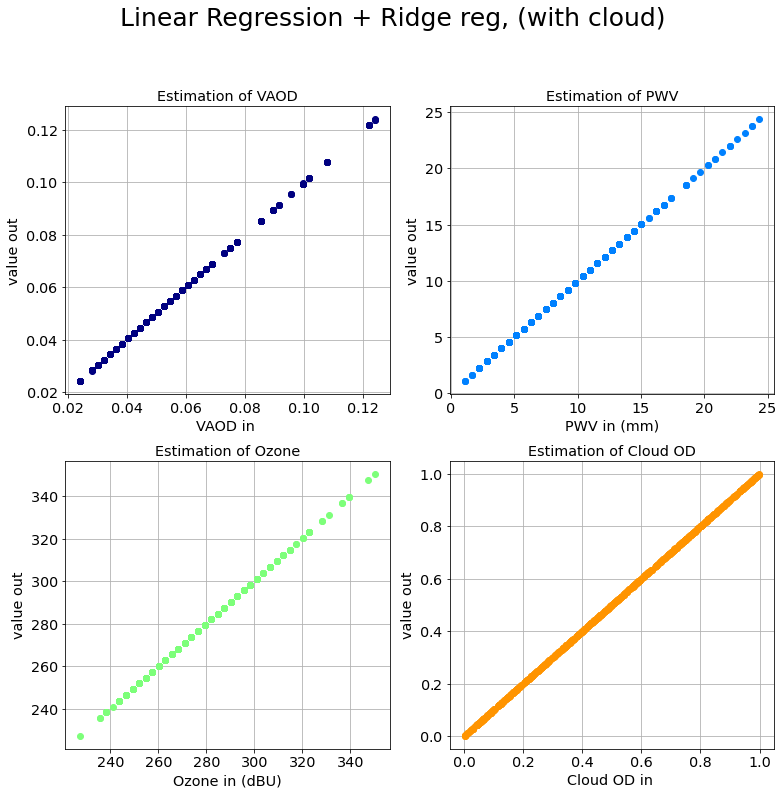

In [459]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

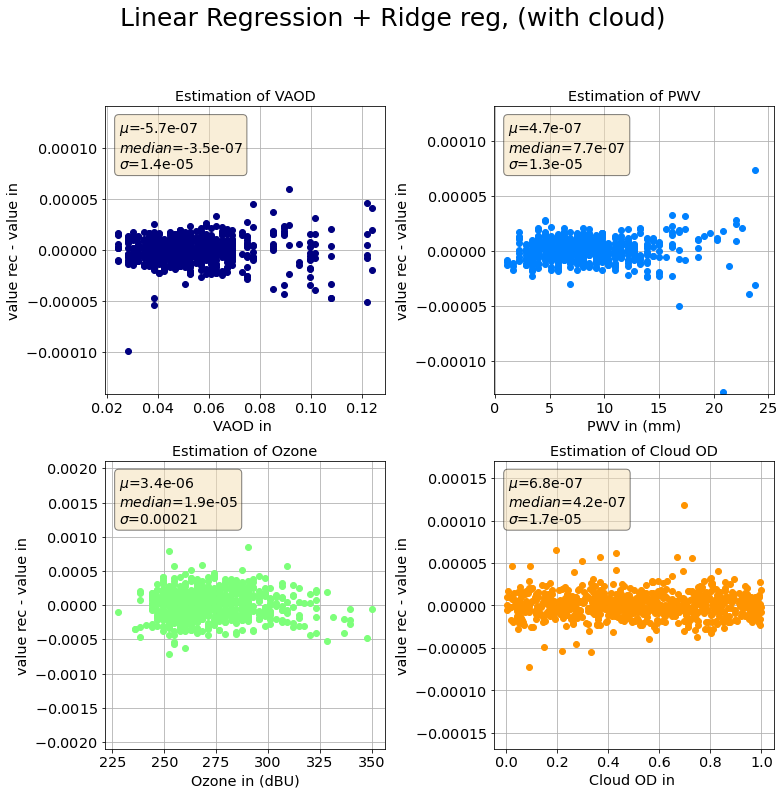

In [460]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

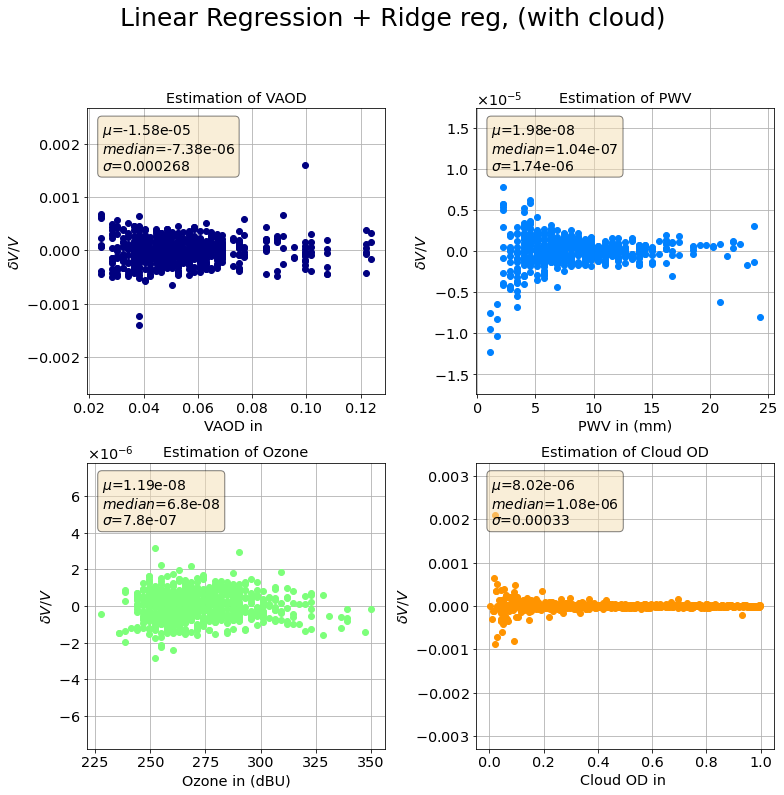

In [461]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

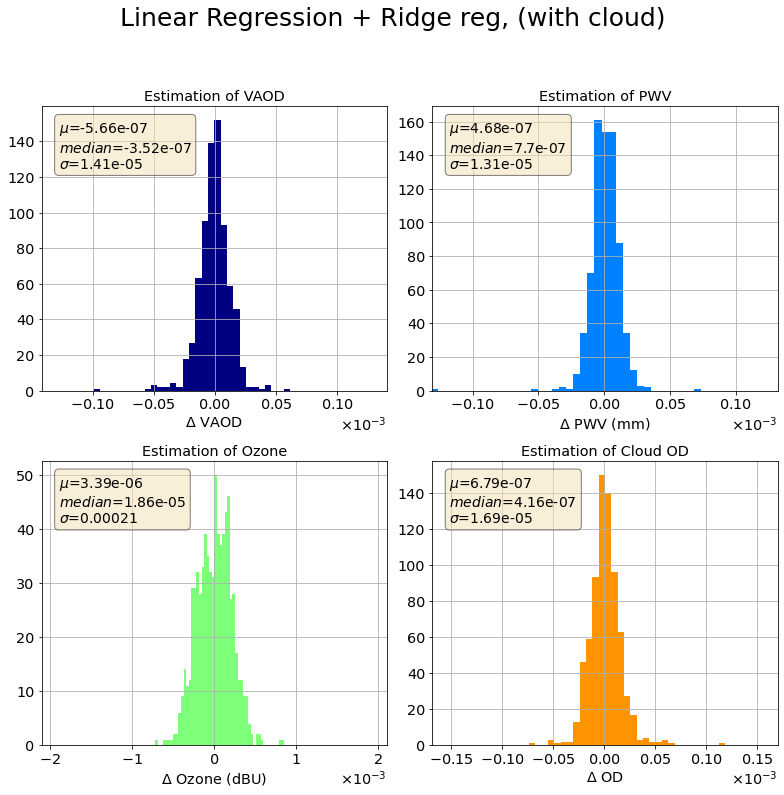

In [462]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

## Lasso

In [463]:
#lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
    
if FLAG_SCALING:           
    lasso.fit(X_train_scaled,Y_train_scaled)
else:
    lasso.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = lasso.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = lasso.predict(X_test)
    DY=Y_pred_test-Y_test
    
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349.8417580282955, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.63497664704339, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 662.3278654934599, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

In [464]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.29271
Coefficient of determination: 0.72461
Explained variance: 0.72489


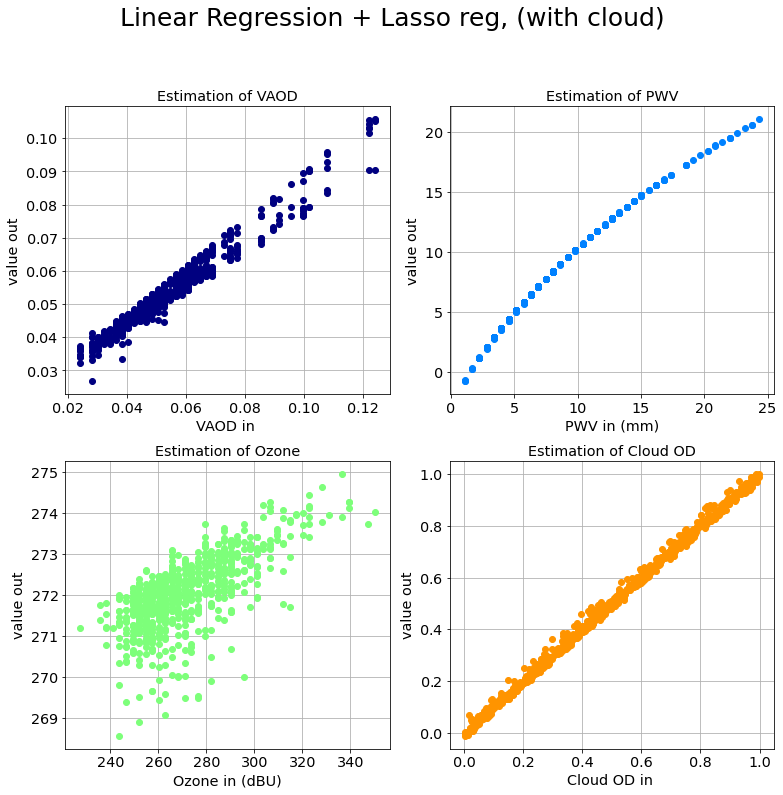

In [465]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

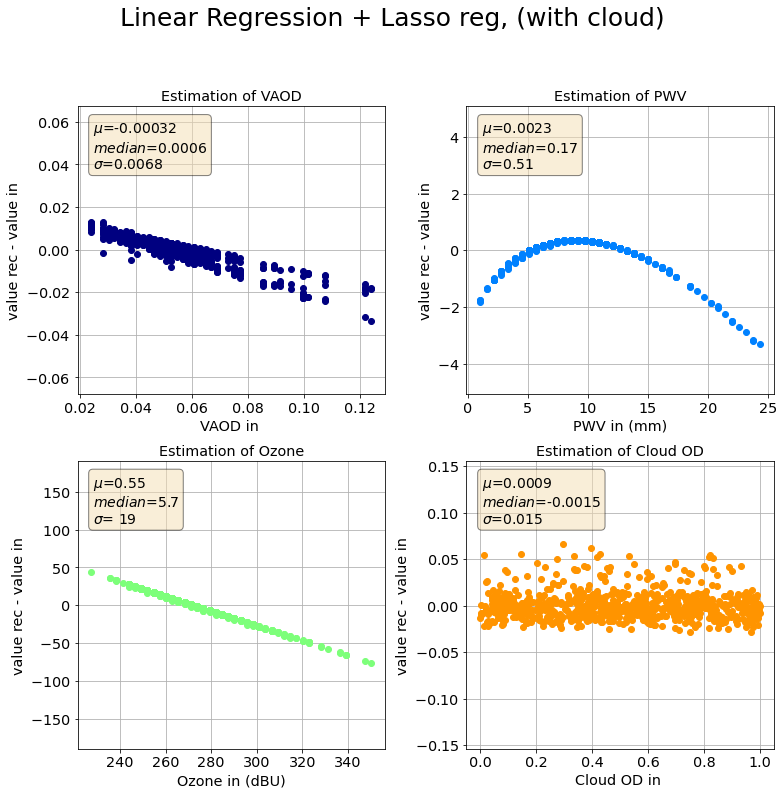

In [466]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

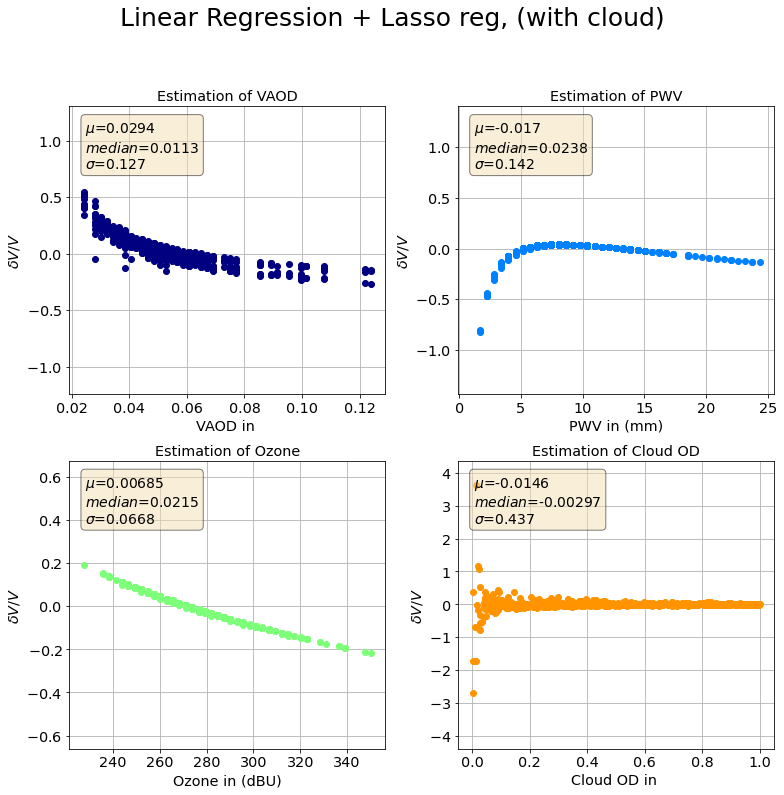

In [467]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

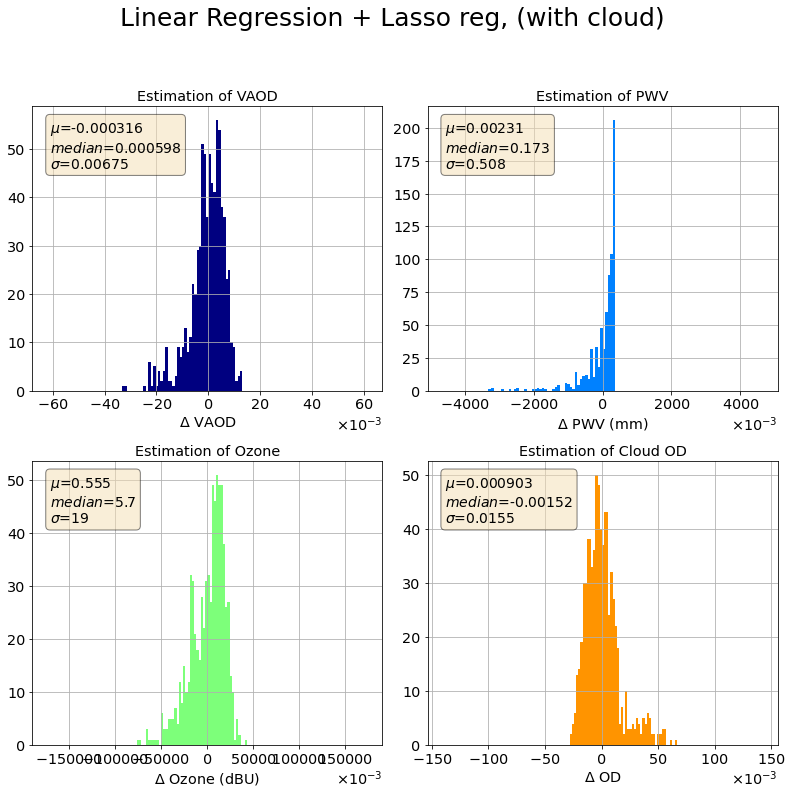

In [468]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()